# TODO

Intro
- EDA (correlation matrix) ; fouskakis

Dataset
- add more columns from codebook

Features
- bmi, weight, height, bmi_group -> avoid multicollinearity
- scaler to columns: height, weight, bmi
- correlation matrix to drop highly correlated features, threshold = 0.75
- feature importance analysis
- one hot encoding to categorical columns
- reduce number of features -> PCA

Balance data
- explore ways to balance data
- SMOTE
- oversample minority class?
- undersample majority class?
- anomaly detection?
- Merge prediabetics with diabetics

Model
- explore classifiers
- grid search -> find best
- model explainability

Extra
- further research -> kaggle notebooks
- counterfactual explanations


Links<br>
https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators<br>
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset<br>
https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf<br>
https://www.kaggle.com/datasets/cdc/behavioral-risk-factor-surveillance-system/data<br>
https://www.cdc.gov/pcd/issues/2019/19_0109.htm<br>
https://www.kaggle.com/code/alexteboul/diabetes-health-indicators-dataset-notebook<br>

# Info

- Έγιναν drop columns που αφορούσαν ερωτήσεις σε άτομα που ήδη έχουν διαβήτη, καθώς και η στήλη prediabetes.
- Αφαιρέθηκαν τα rows με διαβήτη τύπου 1, ο οποίο είναι αυτοάνοσο νόσημα.<br>
0: no diabetes, or only during pregnancy<br>
1: prediabetes<br>
2: diabetes

# Imports

In [25]:
import pandas as pd
import numpy as np
from math import floor
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE # ioanna addition
from imblearn.under_sampling import RandomUnderSampler #undersampler
from imblearn.under_sampling import TomekLinks # undersampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output = 'pandas')
from sklearn.decomposition import PCA

In [26]:
path = 'Data/'

In [27]:
# inputs = pd.read_csv(path + 'diabetes_dataset.csv')
inputs = pd.read_csv(path + 'diabetes_dataset.csv')

# EDA

# Preprocessing

## DatasetPreprocessor

In [43]:
class DatasetPreprocessor:
    def __init__(self, raw, info):
        self.data = raw.copy()
        self.label_name = 'diabetes'
        self.numerical_features = ['sleep_time', 'bmi', 'height', 'weight']
        self.categorical_features = list(set(self.data.columns) - set(self.numerical_features) - set([self.label_name]))
        self.info = info
        
    def convert_type(self):
        for col in self.categorical_features:
            self.data[col] = self.data[col].astype('category')

    def extract_labels(self, train=False):
        if train:
            self.train_labels = self.train_data[[self.label_name]].to_numpy().flatten()
        else:
            self.labels = self.data[[self.label_name]].to_numpy().flatten()

    def remove_labels(self):
        self.data.drop([self.label_name], axis=1, inplace=True)

    def remove_cols(self, cols_to_drop):
        numerical_drops, categorical_drops = [],[]
        for col in cols_to_drop:
            if col in self.numerical_features:
                numerical_drops.append(col)
            else:
                categorical_drops.append(col)
        self.numerical_features = list(set(self.numerical_features)-set(numerical_drops))
        self.categorical_features = list(set(self.categorical_features)-set(categorical_drops)) 
        self.data.drop(cols_to_drop, axis=1, inplace=True)

    def remove_rows(self, column, column_value):
        self.data = self.data[self.data[column]!=column_value]
        
    @staticmethod
    def class_frequencies(data, labels):
        _ , class_samples = np.unique(labels, return_counts=True)
        class_freq = class_samples/len(data)
        return class_freq
    
    @staticmethod
    def binary_labels(labels):
        labels[labels == 2] = 1
        return labels
        
    def DatasetPreprocessorPipeline(self):
        self.remove_rows(column = 'diabetes_type', column_value = 1)
        self.remove_cols(['diabetes_type','currently_insulin','hemoglobin','eye_exam','eye_photo','diabetes_education',
                         'sore_feet','prediabetes'])
        self.extract_labels()
        if self.info['binary_classification']:
            self.labels = self.binary_labels(self.labels)
        self.remove_labels()
        self.convert_type()

## ModelPreprocessor

In [55]:
class ModelPreprocessor(DatasetPreprocessor):
    def __init__(self, raw, info):
        super().__init__(raw, info)
        self.info = info
        self.random_state = self.info['random_state']
    
    def split(self, stratify=True):
        stratify_labels = self.labels if stratify else None
        self.train_data, self.test_data, self.train_labels, self.test_labels = train_test_split(
            self.data,
            self.labels,
            test_size=self.info['test_size'],
            random_state=self.random_state,
            stratify=stratify_labels
        )
    
    def apply_onehot(self):
        self.data = pd.get_dummies(self.data, drop_first=True)
        
    def run_smote(self):
        smote = SMOTE(random_state=self.random_state)
        self.train_data, self.train_labels = self.smote.fit_resample(self.train_data, self.train_labels)
        
    def run_undersampling(self):
        sampling_strategy = {
          0: floor(len(self.train_labels[self.train_labels == 0]) / 3*0.75),
          1: floor(len(self.train_labels[self.train_labels == 1])*0.75),
          2: floor(len(self.train_labels[self.train_labels == 2])*0.75)
          }
        undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy)
        self.train_data, self.train_labels = undersampler.fit_resample(self.train_data, self.train_labels)
        
    def run_equal_sampling(self):
        labels_series = pd.Series(self.train_labels, name=self.label_name)
        min_class_size  = labels_series.value_counts().min()

        # Sample from each class
        balanced_indices = []
        for label in np.unique(self.train_labels):
            # Find indices of each class label
            class_indices = labels_series[labels_series == label].index
            # Sample indices of this class
            sampled_indices = np.random.choice(class_indices, size=min_class_size, replace=False)
            balanced_indices.extend(sampled_indices)

        # Use the sampled indices to select rows from train_data
        self.train_data = self.train_data.iloc[balanced_indices]
        self.train_labels = self.train_labels[balanced_indices]
        
    def run_rare_class_sampling(self):
        class_freq = self.class_frequencies(self.train_data, self.train_labels) 
        T = self.info['RCS']['T']
        num_samples = self.info['RCS']['num_samples']
        probs = np.exp((1 - class_freq) / T)
        probs /= probs.sum()
        probs_to_labels = {}
        for i in range(len(probs)):
            probs_to_labels[i] = probs[i]
        sample_weights = pd.Series(self.train_labels).map(probs_to_labels)

        sampled_indices = np.random.choice(
            a=len(self.train_labels), 
            size=num_samples, 
            replace=False, 
            p=sample_weights / sample_weights.sum()
        )

        # Subset the train_data and train_labels using the sampled indices
        self.train_data = self.train_data.iloc[sampled_indices]
        self.train_labels = self.train_labels[sampled_indices]
        
    def shuffle_data(self):
        shuffle_indices = np.random.permutation(len(self.train_data))
        self.train_data = self.train_data.iloc[shuffle_indices].reset_index(drop=True)
        self.train_labels = self.train_labels[shuffle_indices]
        
    def data_balancing(self):
        # RESAMPLE MUST BE DONE ONLY ON TRAIN DATA
        if self.info['balancing_method']==None:
            pass
        
        # ---SMOTE---
        if self.info['balancing_method']=='smote':
            self.run_smote()
            
        # ---UNDERSAMPLING----
        if self.info['balancing_method']=='undersampling':
            self.run_undersampling()

        # ---EQUAL NUMBER OF LABELS PER CLASS---
        if self.info['balancing_method']=='equal':
            self.run_equal_sampling()
            self.shuffle_data()
            
        # ---RARE CLASS SAMPLING---
        if self.info['balancing_method']=='RCS':
            self.run_rare_class_sampling()
            self.shuffle_data()

    def apply_transformations(self, datatype):
        if datatype=='train':    
            if self.info['apply_scaler']:
                self.scaler = StandardScaler()
                self.train_data[self.numerical_features] = self.scaler.fit_transform(self.train_data[self.numerical_features])
            if self.info['apply_pca']:
                self.pca = PCA(n_components=self.info['pca_components'])
                self.train_data = self.pca.fit_transform(self.train_data)
                print(f'Explained Variance Ratio: {np.sum(self.pca.explained_variance_ratio_)}')
        elif datatype=='test':
            if self.info['apply_scaler']:
                self.test_data[self.numerical_features] = self.scaler.transform(self.test_data[self.numerical_features])
            if self.info['apply_pca']:
                self.test_data = self.pca.transform(self.test_data)
        
        
    def ModelPreprocessorPipeline(self):
        self.DatasetPreprocessorPipeline()
        if self.info['apply_onehot']:
            self.apply_onehot()
        self.split()
        self.data_balancing()
        self.apply_transformations(datatype='train')
        self.apply_transformations(datatype='test')
        
    def get_feature_names(self):
        # Helper function to get feature names from transformer
        feature_names = list(self.data_transformer.named_transformers_['cat'].get_feature_names_out(self.categorical_features))
        feature_names.extend(self.numerical_features)
        return feature_names


In [71]:
info = {
    'random_state':42,
    'binary_classification':True,
    'test_size':0.01,
    'balancing_method':None,
    'RCS': {
        'T': 0.1,
        'num_samples': 100000,
    },
    'apply_scaler':True,
    'apply_pca': False,
    'pca_components':10,
    'apply_onehot':False,
}
# 
# undersampling does not work with binary classification!

In [72]:
data = ModelPreprocessor(inputs, info)
data.ModelPreprocessorPipeline()

In [73]:
len(data.data.columns), len(data.train_data.columns), len(data.test_data.columns)

(24, 24, 24)

In [74]:
len(data.labels), len(data.train_labels), len(data.test_labels)

(242113, 239691, 2422)

In [75]:
np.unique(data.train_labels, return_counts=True)

(array([0, 1], dtype=int64), array([201585,  38106], dtype=int64))

In [76]:
np.unique(data.test_labels, return_counts=True)

(array([0, 1], dtype=int64), array([2037,  385], dtype=int64))

# Model training

## Classifiers

In [12]:
class BaseClassifier:
    def __init__(self, data_object, random_state=42):
        self.random_state = random_state
        self.model = None
        self.data = data_object

    def model_pipeline(self, report=False, fi=False, cm=False):
        self.create_model()
#       self.train_data, self.train_labels, self.test_data, self.test_labels = self.preprocessor.fit_transform()
        self.train()
        if report:
            self.generate_classification_report()
        if fi and hasattr(self, 'feature_importance'):
            self.feature_importance()
        if cm:
            self.plot_confusion_matrix()

    def create_model(self):
        raise NotImplementedError("This method should be overridden by subclasses")

    def train(self):
        print("calling training")
        if self.model is not None:
            self.model.fit(self.data.train_data, self.data.train_labels)
        else:
          print("model is None ")

    def generate_classification_report(self):
#         if self.model is not None:
        predictions = self.model.predict(self.data.test_data)
        print(classification_report(self.data.test_labels, predictions))

    def plot_confusion_matrix(self):
#         if self.model is not None:
        y_pred = self.model.predict(self.data.test_data)
        cm = confusion_matrix(self.data.test_labels, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()


In [13]:
class RandomForestModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)

    def create_model(self):
        self.model = RandomForestClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.data.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()


In [14]:
class XGBoostModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)

    def create_model(self):
        self.model = XGBClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.data.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(6, 6))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()


In [15]:
class LogisticRegressionModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)

    def create_model(self):
        self.model = LogisticRegression(random_state=self.random_state)

In [16]:
class BalancedRandomForestModel(BaseClassifier):
    def __init__(self, data_object, random_state=42):
        super().__init__(data_object, random_state)

    def create_model(self):
        self.model = BalancedRandomForestClassifier(random_state=self.random_state)

    def feature_importance(self):
        if self.model is not None:
            importance = self.model.feature_importances_
            features = self.data.train_data.columns

            indices = np.argsort(importance)
            sorted_importance = np.take(importance, indices, axis=0)
            sorted_features = np.take(features, indices, axis=0)

            plt.figure(figsize=(5,5))
            plt.barh(range(len(sorted_importance)), sorted_importance, align='center')
            plt.yticks(range(len(sorted_importance)), sorted_features)
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.show()

## Implementations

calling training
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      2037
           1       0.00      0.00      0.00        58
           2       0.40      0.76      0.52       327

    accuracy                           0.80      2422
   macro avg       0.44      0.53      0.47      2422
weighted avg       0.84      0.80      0.81      2422



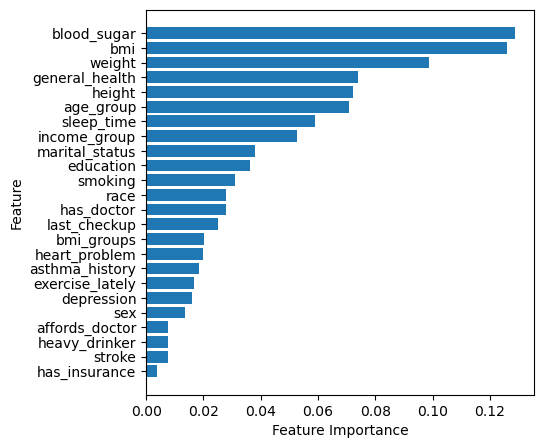

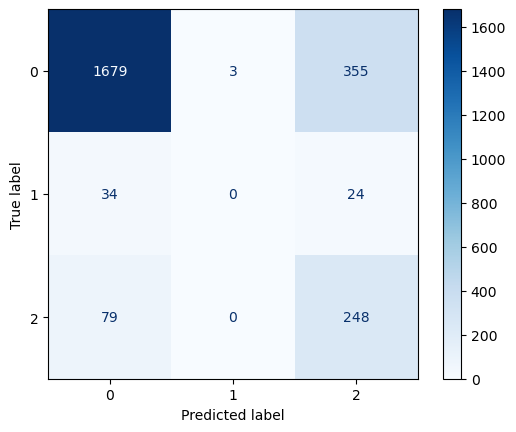

CPU times: total: 4.52 s
Wall time: 20.1 s


In [17]:
%%time
rf1 = RandomForestModel(data) 
rf1.model_pipeline(report=True, fi=True, cm=True)

In [24]:
labels = np.array([0,1,2])
labels[labels == 2] = 1
labels

array([0, 1, 1])